- 이 자료는 핸즈온 머신러닝 책 & 코드를 공부한 내용입니다.

# Chap07 - 앙상블 학습과 랜덤 포레스트

**앙상블(ensemble)**이란 프랑스어이며 뜻은 *조화* 또는 *통일*을 의미한다. 

머신러닝에서 여러개의 모델을 학습시켜 그 모델들의 예측결과들을 이용해 하나의 모델보다 더 나은 값을 예측하는 방법을 말한다. 이러한 방법을 **앙상블 학습**(ensemble learning) 또는 **앙상블 방법**(ensemble method)이라고 한다.

앙상블 학습의 대표적인 예로는 **랜덤 포레스트**(Random Forest)가 있다. 랜덤포레스트는 여러개의 의사결정나무(decision tree)들을 생성한 다음, 각 개별 트리의 예측값들 중에서 가장 많은 선택을 받은 클래스(또는 label)로 예측하는 알고리즘이다.

이번 장에서는 랜덤포레스트 뿐만아니라 **배깅, 부스팅, 스태킹** 등 앙상블 학습에 대해 알아 보도록 하자.

## SetUp

In [1]:
import os
import numpy as np

# 일관된 출력을 위해 유사난수 초기화
np.random.seed(42)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
sn.set()
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
# matplotlib.rc('font', family='AppleGothic')  # MacOS
matplotlib.rc('font', family='Malgun Gothic')  # Windows
plt.rcParams['axes.unicode_minus'] = False

## 7.1 투표 기반 분류기(Voting Classifier)

투표 기반 분류기는 아래의 그림에서 볼 수 있듯이, 학습 단계에서 여러개의 머신러닝 알고리즘 모델을 학습시킨 후 이러한 모델들을 이용해 새로운 데이터에 대해 각 모델의 예측값을 가지고 **다수결 투표**를 통해 최종 클래스를 예측하는 방법을 말한다. 이러한 분류기를 **직접 투표**(hard voting) 분류기라고 한다.

![](./img/ensemble02.png)

이러한 다수결 투표 분류기가 앙상블에 포함된 개별 분류기(위의 그림에서는 LR, RF, SVM, ...) 중 가장 성능이 좋은 분류기 보다 정확도가 더 높을 경우가 많다고 한다. 

### 투표 분류기가 더 좋은 이유 - 중요

예를 들어 앞면이 나올 확률이 51%이고, 뒷면이 나올 확률이 49%인 동전 던지기를 한다고 가정하자. 이러한 동전을 1,000번 던지면 약 510번은 앞면, 490번은 뒷면이 나오게 될것이다. 따라서 더 많은 횟수로 앞면이 나온다는 것을 알 수 있다. 이를 수학적으로 계산해보면 1,000번을 던진 후 앞면이 더 많이 나올 확률은 75%에 가까운 것을 알 수 있다. 동전 던지기는 이항분포이므로 다음과 같이 나타낼 수 있다.

$$
\binom{n}{k} p^{k}\left( 1-p \right)^{n-k}
$$

위의 식을 이용해 0~499 까지의 누적 분포 함수(CDF, Cumulative Distribution Function)를 이용해 누적 확률을 계산한 뒤, 전체 확률 1에서 빼주면 75%를 구할 수 있다. 이를 [`SciPy`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom.html)를 이용해 `1-scipy.stats.binom.cdf(499, 1000, 0.51)` 구할 수 있다. 또한, 동전을 10,000번 던진다면 앞면이 더 많이 나올 확률이 97%(`1 - scipy.stats.binom.cdf(4999, 10000, 0.51)`) 이상으로 올라간다. 

이와 비슷하게 51% 정확도를 가진 1,000개의 분류기로 앙상블 모델을 구축할 경우 정확도는 75%로 기대할 수 있다. 그러나 이러한 가정은 모든 분류기가 독립적이어야 하고, 오차에 대해 상관관계가 없어야 한다. 

따라서, 앙상블 기법에서 독립적인 모델을 만들어 주기 위해서는 다른 머신러닝 알고리즘으로 학습시키는 것이 좋다. 그 이유는 모델 별로 다른 종류의 오차를 가지므로 상관관계가 작어지기 때문이다.

In [2]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

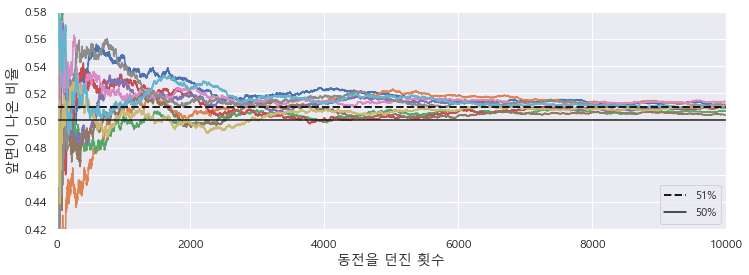

In [3]:
plt.figure(figsize=(12, 4))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("동전을 던진 횟수")
plt.ylabel("앞면이 나온 비율")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.show()

### moons 데이터셋에 앙상블 학습 적용하기

위에서 살펴본 투표 분류기를 Scikit-Learn의 [`VotingClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)를 이용해 예제 데이터셋인 `moons`데이터 셋에 적용해보자. `moons` 데이터셋은 Scikit-Learn에서 제공하는 반달 모양의 데이터셋이다.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#### Hard voting

`VotingClassifier`에서 `voting='hard'` 인 경우 각 분류기의 예측값(레이블)을 가지고 다수결 투표를 통해 최종 앙상블 예측이 이루어진다.

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [6]:
# LabelEncoder 버그로 인해 생기는 DeprecationWarning 막기
# https://github.com/scikit-learn/scikit-learn/pull/9816
# https://stackoverflow.com/questions/49545947/sklearn-deprecationwarning-truth-value-of-an-array
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [7]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


#### Soft voting

`VotingClassifier`에서 `voting='soft'` 인 경우 각 분류기의 예측값(레이블)의 확률을 가지고 평균을 구한 뒤, 평균이 가장 높은 클래스로 최종 앙상블 예측이 이루어진다. 이러한 방법을 **간접 투표**(soft voting)이라 한다.

- 결국 Hard와 Soft의 차이는 결과 클래스 vs 확률의 사용

In [8]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [9]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92
